In [1]:
import requests
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
import numpy as np

### Intro

*"The 27 Club is an informal list consisting mostly of popular musicians, artists, actors, and other celebrities who died at age 27."* (https://en.wikipedia.org/wiki/27_Club)

27 Club features, among others, Kurt Cobain, Brian Jones, Amy Winehouse. There is even a [book](https://www.amazon.com/27-History-through-Morrison-Winehouse/dp/0306821680/ref=la_B001IOH9LK_1_1?ascsubtag=___vx__p_8041312__t_w__r_en.wikipedia.org__d_D&s=books&ie=UTF8&qid=1415056518&sr=1-1) on this. Big names, sudden deaths. It attracts attention and suggests a mysterious pattern: is it really true that most young rising stars die at 27?

It's not. As [has been shown](https://theconversation.com/the-27-club-is-a-myth-56-is-the-bum-note-for-musicians-33586), most musicians die around 56, which sounds much less mysterious.

Now, there is a similar phenomenon in Russian culture: 37.  
Pushkin, Nekrasov, Nikitin, Gaidar are high profile examples, while Mayakovsky, Odoevsky, Harms died at 36.  

Does club 37 exist or is it an illusion, sparked by few high-profile cases? 

One way to proceed to is to parse list of Russian-language poets and writers from Wikipedia.

### Attempt I
The easiest way to proceed is to parse lists of Russian-language poets and writers: 
- https://en.wikipedia.org/wiki/List_of_Russian-language_writers
- https://en.wikipedia.org/wiki/List_of_Russian-language_poets

Each entry comes with a lifespan  


In [2]:
page = requests.get('https://en.wikipedia.org/wiki/List_of_Russian-language_writers')
bs = BeautifulSoup(page.content)
li = bs.find_all('li')

In [3]:
age_writers = {}
lifespan_writers = {}
for entry in tqdm(li):
    res = re.search('(\d\d\d\d).(\d\d\d\d)', entry.text)
    if res is not None:
        link = f"https://en.wikipedia.org/{entry.contents[0]['href']}"
        age_writers[link] = int(res.group(2))-int(res.group(1))
        lifespan_writers[link] = (int(res.group(1)), int(res.group(2))) 

100%|██████████| 1563/1563 [00:00<00:00, 42802.37it/s]


In [8]:
ages = np.array(list(age_writers.values()))

In [9]:
ages.min(), ages.max()

(1, 98)

1 turns out to be a parsing error 

In [11]:
{k for k,v in age_writers.items() if v==1}

{'https://en.wikipedia.org//wiki/Anna_Mitrofanovna_An%C3%ADchkova'}

In [12]:
age_writers['https://en.wikipedia.org//wiki/Anna_Mitrofanovna_An%C3%ADchkova'] = 1935-1869
lifespan_writers['https://en.wikipedia.org//wiki/Anna_Mitrofanovna_An%C3%ADchkova'] = (1869, 1935)

In [14]:
ages = np.array(list(age_writers.values()))
ages.min(), ages.max()

(17, 98)

This looks more reasonable. Let's check if 17 is real. 

In [15]:
{k for k,v in age_writers.items() if v==17}

{'https://en.wikipedia.org//wiki/Mikhail_Sushkov'}

>Mikhail Vasilyevich Sushkov (Russian: Михаил Васильевич Сушков) (1775–1792) was a young Russian nobleman and writer of a small body of prose and poetry, notable for his autobiographical suicide novel. He committed suicide by hanging at age 16 after writing four suicide notes [...]

Now to the poets. Page layout is different, it's a table instead of a list, but still easy to parse.

In [17]:
page = requests.get('https://en.wikipedia.org/wiki/List_of_Russian-language_poets')
bs = BeautifulSoup(page.content)
td = bs.find_all('td') 

In [18]:
age_poets = {}
lifespan_poets = {}
td = bs.find_all('td') 
for entry in tqdm(td):
    if entry.contents[0].name == 'b':
        res = re.search('(\d\d\d\d).(\d\d\d\d)', entry.contents[-1].text)
        if res is not None:
            link = f"https://en.wikipedia.org/{entry.contents[0].contents[0]['href']}"
            age_poets[link] = int(res.group(2))-int(res.group(1))
            lifespan_poets[link] = (int(res.group(1)), int(res.group(2))) 

100%|██████████| 709/709 [00:00<00:00, 272347.43it/s]


In [19]:
ages = np.array(list(age_poets.values()))
ages.min(), ages.max()

(22, 96)

In [20]:
len(set.intersection( set(age_writers.keys()), set(age_poets.keys()))), len(age_poets), len(age_writers)

(175, 210, 633)

Most of the poets are writers. Let's perform a sanity check to ensure we obtained the same values from two lists.

In [21]:
[ (k, age_writers[k], age_poets[k]) for k in set.intersection( set(age_writers.keys()), set(age_poets.keys())) if age_writers[k]!=age_poets[k]]

[('https://en.wikipedia.org//wiki/Nikolay_Yazykov', 43, 44),
 ('https://en.wikipedia.org//wiki/Yevdokiya_Rostopchina', 47, 46),
 ('https://en.wikipedia.org//wiki/Afanasy_Fet', 72, 80),
 ('https://en.wikipedia.org//wiki/Kozma_Prutkov', 60, 58),
 ('https://en.wikipedia.org//wiki/Veronika_Tushnova', 54, 50),
 ('https://en.wikipedia.org//wiki/Vasily_Trediakovsky', 65, 66)]

Curious. One-year discrepancies might be due to New Style vs Old Style calendar systems. This is the case for Yazykov and Rostopchina. But Trediakovsky's lifespan is (1703-1768) according to the Russian wiki page and (1703-1769) according to English one. I'd opt for Russian version. Discrepancy for Afanasy Fet's entry is eight years. It's wrong, actual lifespan is 1820-1892. 

Here are more interesting exceptions.

1. Kozma Prutkov is a collective pseudonym 

2. For Tushnnova the difference is four years. A typo? In fact Russian page lists two dates of birth in the infobox and explains:

*В ряде биографических статей и автобиографий годом рождения Тушновой указан 1915 год. Даты 1915—1965 выгравированы на памятнике на могиле [...]
Клуб любителей поэзии Вероники Тушновой провёл исследование и нашёл выписку из метрической книги о её крещении в 1911 году. Эту дату подтвердила и дочь поэтессы Н. Розинская* 

In [22]:
age_writers.update(age_poets)
lifespan_writers.update(lifespan_poets)

In [23]:
age_writers['https://en.wikipedia.org//wiki/Nikolay_Yazykov'] = 44
lifespan_writers['https://en.wikipedia.org//wiki/Nikolay_Yazykov'] = (1803, 1847)

age_writers['https://en.wikipedia.org//wiki/Vasily_Trediakovsky'] = 65
lifespan_writers['https://en.wikipedia.org//wiki/Vasily_Trediakovsky'] = (1703, 1768)

age_writers['https://en.wikipedia.org//wiki/Veronika_Tushnova'] = 54
lifespan_writers['https://en.wikipedia.org//wiki/Veronika_Tushnova'] = (1911, 1965)

age_writers['https://en.wikipedia.org//wiki/Afanasy_Fet'] = 72
lifespan_writers['https://en.wikipedia.org//wiki/Afanasy_Fet'] = (1820, 1892)

del age_writers['https://en.wikipedia.org//wiki/Kozma_Prutkov']
del lifespan_writers['https://en.wikipedia.org//wiki/Kozma_Prutkov']

In [31]:
ages = np.array(list(age_writers.values()))
cnt = np.bincount(ages)

In [32]:
sorted(list(zip(np.arange(np.max(ages)+1),cnt)),
        key=lambda x: -x[1])[:15]

[(77, 26),
 (63, 20),
 (68, 20),
 (65, 19),
 (60, 16),
 (61, 16),
 (37, 15),
 (74, 15),
 (75, 15),
 (49, 14),
 (53, 14),
 (54, 14),
 (62, 14),
 (64, 14),
 (73, 14)]

### Discussion
There are a few drawbacks to this approach:
1. Some people die before reaching current year's birthday, which means their age at death is one year less than lifespan suggests
2. Some less known artists might be missing from English wiki list. Cf [this list](https://ru.wikipedia.org/wiki/%D0%9A%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D1%8F:%D0%9F%D0%BE%D1%8D%D1%82%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8)

### Attempt II
More general approach (but surely, still prone to errors) is to parse individual pages of the authors from the top-level list. Biographic pages feature convenient info-boxes with dates of birth and death, among other things.

After some trial-and-error I've come to this scheme
`(?:(\d{1,2}\s){0,1}(?:\(.+?\)\s){0,1}(\w+)\s(?:\(.+?\)\s|\[.+?\]\s){0,1}){0,1}(\d{4})`

which captures the following cases:
- full date is present, eg 16 июня 1846
- full date plus Old style, eg 30 октября [11 ноября] 1821 or 30 октября (11 ноября) 1821
- partial date, eg ноябрь 1921 or a year alone

When at least both months of birth and death are present, we adjust one-year-bias, mentioned above (with days unknown, equal months imply no adjustment). When at least one month is unknown, no adjustment is undertaken.

Artists, who are still alive, are filtered out 

In [2]:
month2id = dict(zip(['января', 'февраля', 'марта', 'апреля', 'мая', 'июня', 'июля', 
                     'августа', 'сентября', 'октября', 'ноября', 'декабря'],
                    range(12)))

month2id_2 = dict(zip(['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 
                     'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь'],
                    range(12)))

def try_infobox(bs):
    ib = bs.select('.infobox')
    if len(ib)==0:
        return (-1,-1)

    r = '(?:(\d{1,2}\s){0,1}(?:\(.+?\)\s){0,1}(\w+)\s(?:\(.+?\)\s|\[.+?\]\s){0,1}){0,1}(\d{4})'
    m_birth = re.search(f'Дата\sрождения\n\n{r}', ib[0].text)
    m_death = re.search(  f'Дата\sсмерти\n\n{r}', ib[0].text)
    
    if m_death is None:
        m_death = re.search('Дата\sсмерти\n\n', ib[0].text)
        if m_death is None:
            return (-1, -2)
        else:
            return (-1, -3)
    
    if m_birth is None:
        m_birth = re.search('Дата\sрождения\n\n', ib[0].text)
        if m_birth is None:
            return (-1, -4)
        else:
            return (-1, -5)
    y1, y0 = int(m_death.group(3)), int(m_birth.group(3))
    age = y1 - y0
    if (m_death.group(2) is not None) and (m_birth.group(2) is not None):
        dmonth = m_death.group(2).lower()
        bmonth = m_birth.group(2).lower()

        if (m_death.group(1) is not None) and (m_birth.group(1) is not None):
            diff = month2id[dmonth] * 31 + int(m_death.group(1)) - \
                month2id[bmonth] * 31 - int(m_birth.group(1))
        else:
            md = month2id_2[dmonth] if dmonth in month2id_2 else month2id.get(dmonth,-1)
            mb = month2id_2[bmonth] if bmonth in month2id_2 else month2id.get(bmonth,-1)
            diff = md - mb
            if (mb==-1) or (md==-1):
                diff=0
        if diff<0:
            age-=1
    return age, (y0, y1)

In [3]:
err_codes = {-1: 'no infobox',
             -2: 'still alive',
             -3: 'death date parsing error',
             -4: 'no birth date',
             -5: 'birth date parsing error',
             }

In [2]:
base_url = 'https://ru.wikipedia.org'

In [3]:
from collections import defaultdict
import urllib

In [4]:
def process_all_pages(start_page, links_all):
    next_page = [start_page]
    while len(next_page)>0:
        #print(f'{base_url}/{next_page[0]}')
        resp = requests.get(f'{base_url}/{next_page[0]}')
        soup = BeautifulSoup(resp.content, 'lxml')

        li = [x for x in soup.select('li') if (x.contents[0].name=='a') and (x.attrs=={})]
        links = [x.contents[0]['href'] for x in li]
        links_all.update(links)

        next_page = [x['href'] for x in soup.find_all('a') if x.text=='Следующая страница']    

In [5]:
links_all = set()
# writers of Russia
process_all_pages('/w/index.php?title=%D0%9A%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D1%8F:%D0%9F%D0%B8%D1%81%D0%B0%D1%82%D0%B5%D0%BB%D0%B8_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8&pagefrom=%D0%92%D0%B0%D0%B2%D0%B8%D0%BB%D0%B8%D0%BD%2C+%D0%98%D0%B2%D0%B0%D0%BD+%D0%9C%D0%B8%D1%85%D0%B0%D0%B9%D0%BB%D0%BE%D0%B2%D0%B8%D1%87#mw-pages', links_all)
# writers of Ru Empire
process_all_pages('/wiki/%D0%9A%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D1%8F:%D0%9F%D0%B8%D1%81%D0%B0%D1%82%D0%B5%D0%BB%D0%B8_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B9%D1%81%D0%BA%D0%BE%D0%B9_%D0%B8%D0%BC%D0%BF%D0%B5%D1%80%D0%B8%D0%B8', links_all)
# writers of the Soviet Union
process_all_pages('/wiki/%D0%9A%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D1%8F:%D0%9F%D0%B8%D1%81%D0%B0%D1%82%D0%B5%D0%BB%D0%B8_%D0%A1%D0%A1%D0%A1%D0%A0', links_all)

# Russian poets
process_all_pages('/wiki/%D0%9A%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D1%8F:%D0%A0%D1%83%D1%81%D1%81%D0%BA%D0%B8%D0%B5_%D0%BF%D0%BE%D1%8D%D1%82%D1%8B', links_all)

In [8]:
len(links_all)

8063

In [9]:
sorted([urllib.parse.unquote(k, 
                      encoding='utf-8') for k in links_all], key = lambda x: x.split('/')[-1].split(',')[0])[:40]

['https://ru.wikipedia.org/w/index.php?title=Категория:Писатели_СССР&from=Алт',
 'https://ru.wikipedia.org/w/index.php?title=Категория:Писатели_СССР&from=Бит',
 'https://ru.wikipedia.org/w/index.php?title=Категория:Писатели_СССР&from=Вин',
 'https://ru.wikipedia.org/w/index.php?title=Категория:Писатели_СССР&from=Гно',
 'https://ru.wikipedia.org/w/index.php?title=Категория:Писатели_СССР&from=Дин',
 'https://ru.wikipedia.org/w/index.php?title=Категория:Писатели_СССР&from=Ели',
 'https://ru.wikipedia.org/w/index.php?title=Категория:Писатели_СССР&from=Жиг',
 'https://ru.wikipedia.org/w/index.php?title=Категория:Писатели_СССР&from=Зее',
 'https://ru.wikipedia.org/w/index.php?title=Категория:Писатели_СССР&from=Имп',
 'https://ru.wikipedia.org/w/index.php?title=Категория:Писатели_СССР&from=Кож',
 'https://ru.wikipedia.org/w/index.php?title=Категория:Писатели_СССР&from=Леп',
 'https://ru.wikipedia.org/w/index.php?title=Категория:Писатели_СССР&from=Мер',
 'https://ru.wikipedia.org/w/index.php?t

urls, starting with `https` were captured by mistake. Remove them

In [10]:
for url in [x for x in links_all if x.startswith('https')]:
    links_all.remove(url)

In [112]:
links_poets = set()
process_all_pages('/wiki/%D0%9A%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D1%8F:%D0%A0%D1%83%D1%81%D1%81%D0%BA%D0%B8%D0%B5_%D0%BF%D0%BE%D1%8D%D1%82%D1%8B', links_poets)
links_writers = set()
process_all_pages('/wiki/%D0%9A%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D1%8F:%D0%A0%D1%83%D1%81%D1%81%D0%BA%D0%B8%D0%B5_%D0%BF%D0%B8%D1%81%D0%B0%D1%82%D0%B5%D0%BB%D0%B8', links_writers)

In [113]:
len(set.intersection(links_poets, links_writers)), len(links_writers), len(links_poets)

(16, 114, 2180)

In [158]:
age_dict = {}
lifespan_dict = {}
excepts = defaultdict(list)

In [159]:
start = 0

In [160]:
for i,link in tqdm(enumerate(list(links_all)[start:]), total=len(links_all)-start):
    url = f'{base_url}/{link}'
    page = requests.get(url)
    bs = BeautifulSoup(page.content)
    
    res = try_infobox(bs)
    if res[0]>0:
        age_dict[url] = res[0]
        lifespan_dict[url] = res[1]
    else:
        excepts[err_codes[res[1]]].append(url)

100%|██████████| 8034/8034 [1:23:55<00:00,  1.60it/s]


In [97]:
page = requests.get('https://ru.wikipedia.org/wiki/%D0%9F%D1%83%D1%88%D0%BA%D0%B8%D0%BD,_%D0%90%D0%BB%D0%B5%D0%BA%D1%81%D0%B0%D0%BD%D0%B4%D1%80_%D0%A1%D0%B5%D1%80%D0%B3%D0%B5%D0%B5%D0%B2%D0%B8%D1%87')
bs = BeautifulSoup(page.content)
try_infobox(bs)

(37, (1799, 1837))

In [12]:
import json

In [189]:
#with open('age_dict.json', 'w') as f:
#    json.dump(age_dict, f)

#with open('lifespan_dict.json', 'w') as f:
#    json.dump(lifespan_dict, f)

#with open('errors_dict.json', 'w') as f:
#    json.dump(excepts, f)

In [13]:
with open('age_dict.json', 'r') as f:
    age_dict = json.load(f)

with open('lifespan_dict.json', 'r') as f:
    lifespan_dict = json.load(f)

with open('errors_dict.json', 'r') as f:
    excepts = json.load(f)

In [14]:
[(k, len(excepts[k])) for k in excepts]

[('still alive', 1691),
 ('no birth date', 18),
 ('no infobox', 90),
 ('death date parsing error', 99),
 ('birth date parsing error', 26)]

Let's skim through the errors. Where infobox is not available we may examine the first paragraph of the text

In [122]:
def parse_intro(url):
    resp = requests.get(url)
    bs = BeautifulSoup(resp.content, 'lxml')
    ps = bs.find_all('p')
    i = 0
    while (i<len(ps)) and (ps[i].contents[0].name!='b'):
        i+=1
    return ps[i].text if i<len(ps) else -1

In [163]:
[(i, parse_intro(url)) for i,url in enumerate(excepts['death date parsing error'])]

[(0,
  'Александр Николаевич Молчанов (1847 (1847), Казанская губерния, Российская империя\xa0— не ранее 1916)\xa0— русский писатель и журналист, издатель, прозаик,  публицист.\n'),
 (1,
  'Серге́й Ада́мович Колба́сьев (3\xa0(15)\xa0марта\xa01899, Одесса, Херсонская губерния, Российская империя[прим. 1]—30 октября 1937/30 октября 1942[прим. 2])\xa0— русский и советский моряк, прозаик-маринист, поэт, радиолюбитель, энтузиаст джаза.\n'),
 (2, 'Василий Щепочкин\xa0— российский писатель XIX века.\n'),
 (3,
  'Никола́й Семёнович Соколо́в (конец 1810-х\xa0— после 1850)\xa0— русский водевилист 1830—1840-х годов, поэт, возможный автор песни «Шумел, горел пожар московский».\n'),
 (4,
  'Николай Дмитриевич Бутовский (1850—после 1917[2]) — военный писатель, генерал от инфантерии Русской императорской армии.\n'),
 (5,
  'Александр Михайлович Муратов (9 октября 1900\xa0— пропал без вести в июне 1942-го)\xa0— русский советский писатель, редактор, фронтовой корреспондент, педагог. Член Союза писателе

In [164]:
[(i, parse_intro(url)) for i,url in enumerate(excepts['no infobox'])]

[(0,
  'Семенцов Иван (Донецкий Бард)\xa0— революционер, поэт, участник Гражданской войны в Донбассе.\n'),
 (1, -1),
 (2, -1),
 (3,
  'Цви́-Ги́рш (Григо́рий Изра́илевич) Прейгерзо́н (псевдоним\xa0— А.Цфони; 1900, Шепетовка Волынской губернии\xa0— 1969, Москва; прах захоронен в киббуце Шфаим, Израиль)\xa0— еврейский писатель, писавший на иврите. Известен также как крупный специалист в области обогащения угля, автор учебников, монографий и изобретений, доцент Московского Горного института (сегодня – Горный институт НИТУ «МИСиС»).\n'),
 (4,
  'Семён Емельянович Родзянко (1782 (1782)—1808?)\xa0— русский поэт и прозаик конца XVIII\xa0— начала XIX веков.\n'),
 (5,
  'Яков Исаакович Явчуновский (1922—1988)\xa0— театровед, доктор искусствоведения[1].\n'),
 (6,
  'Александр Александрович Петров-Агатов (настоящая фамилия — Петров[1]) (1921, Славгород, Омская губерния — 1986[2]) — советский русский поэт, писатель, переводчик, диссидент, политический заключенный, а также мошенник.\n'),
 (7,
  'Кир

Many of the dates are uncertain or absent. The format doesn't look uniform enough to spend much time on heuristics

In [15]:
ages = np.array(list(age_dict.values()))

In [16]:
ages.min(), ages.max()

(15, 104)

In [17]:
{k for k,v in age_dict.items() if v in [15, 104]}

{'https://ru.wikipedia.org//wiki/%D0%9A%D0%BE%D1%80%D0%B6,_%D0%9D%D0%B8%D0%BA%D0%B8%D1%82%D0%B0_%D0%9B%D0%B5%D0%BE%D0%BD%D1%82%D1%8C%D0%B5%D0%B2%D0%B8%D1%87',
 'https://ru.wikipedia.org//wiki/%D0%9C%D0%BE%D1%80%D1%8F%D0%BA%D0%BE%D0%B2,_%D0%9F%D1%91%D1%82%D1%80_%D0%A4%D0%B0%D0%B4%D0%B5%D0%B5%D0%B2%D0%B8%D1%87',
 'https://ru.wikipedia.org//wiki/%D0%A0%D1%83%D0%B4%D0%B0%D1%88%D0%B5%D0%B2%D1%81%D0%BA%D0%B8%D0%B9,_%D0%98%D1%81%D0%B0%D0%B0%D0%BA_%D0%98%D0%BB%D1%8C%D0%B8%D1%87'}

In [18]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 8})
plt.style.use('seaborn-v0_8-darkgrid')

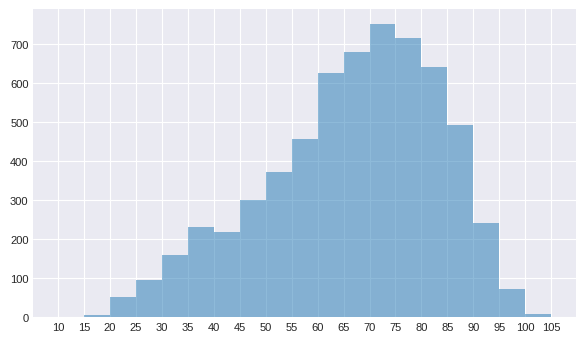

In [19]:
fig,ax=plt.subplots(figsize=(6,3))
ax.hist(ages, bins=np.arange(10, 110, 5), alpha=0.5)
ax.set_xticks(np.arange(10, 110, 5));

In [20]:
cnt = np.bincount(ages)

sorted(list(zip(np.arange(np.max(ages)+1),cnt)),
        key=lambda x: -x[1])[:15]

[(72, 160),
 (77, 156),
 (80, 156),
 (73, 153),
 (74, 152),
 (76, 151),
 (67, 147),
 (71, 146),
 (79, 145),
 (75, 143),
 (82, 142),
 (69, 140),
 (70, 140),
 (65, 136),
 (66, 134)]

37 is nowhere to be seen on the histogram or in the frequency list. Let's see if a cluster of 36, 37, 38 stands out among all three-years clusters  


In [25]:
cnt[36:39].sum()

151

In [29]:
sorted([(i, cnt[i:i+3].sum()) for i in range(cnt.shape[0]-3)], key=lambda x: -x[1])[:15]

[(72, 465),
 (71, 459),
 (75, 450),
 (73, 448),
 (70, 446),
 (74, 446),
 (69, 426),
 (76, 426),
 (79, 422),
 (77, 420),
 (78, 420),
 (80, 419),
 (65, 417),
 (67, 410),
 (66, 404)]

It doesn't. Another possibility is that 37 was most frequent during one specific period of time. Typically, life expectancy at birth grows as we get into modern times. Here are the distributions for artists, born in specific 50-year windows, from 1700-1750 to 1900-1950 

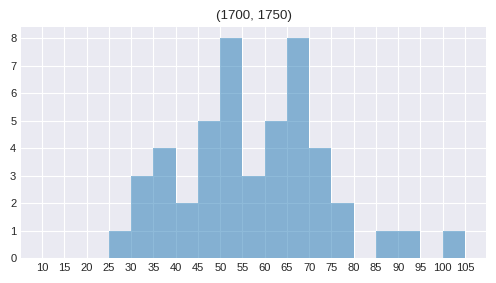

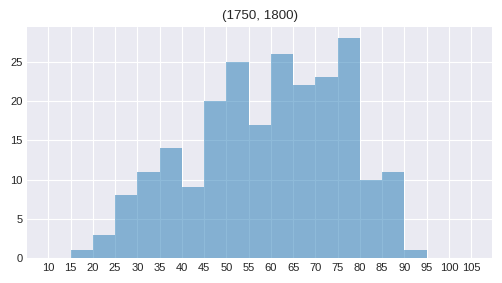

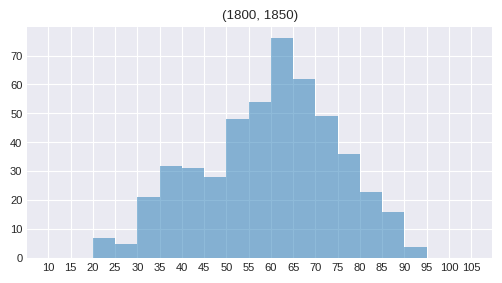

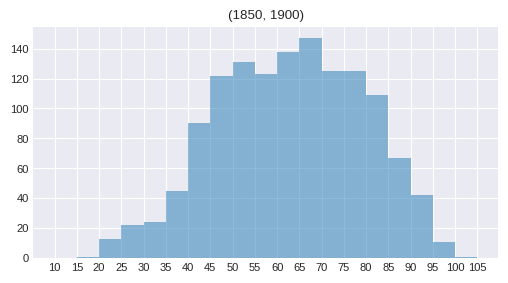

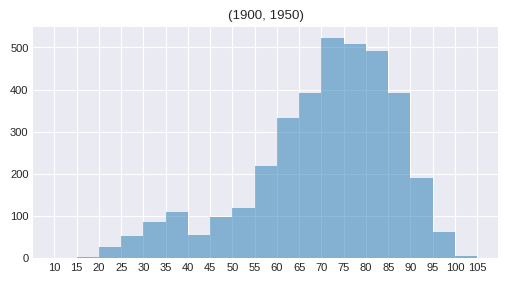

In [33]:
for cutoff in np.arange(1700, 1950, 50):
    ages = np.array([v for k,v in age_dict.items() if (lifespan_dict[k][0]>cutoff) and (lifespan_dict[k][0]<cutoff+50)])
    fig,ax=plt.subplots(figsize=(6,3))
    ax.hist(ages, bins=np.arange(10, 110, 5), alpha=0.5)
    ax.set_xticks(np.arange(10, 110, 5));
    ax.set_title((cutoff, cutoff+50))  

In three periods out of four there is a mode around 37, but it's never the biggest one.